# Foward Modeling of Jupiter-like Ammonia Clouds and Its Reflection Spectrum 

Note:

To run this tutorial, you need to install PyMieScatt.

`pip install PyMieScatt`

See https://pymiescatt.readthedocs.io/en/latest/

In [1]:
import jax.numpy as jnp
import numpy as np

Sets the wavenumber range and the atmosphere model

In [2]:
from exojax.utils.grids import wavenumber_grid

N = 10000
nus, wav, res = wavenumber_grid(10**3, 10**4, N, xsmode="premodit")

from exojax.spec.atmrt import ArtReflectPure
from exojax.utils.astrofunc import gravity_jupiter

art = ArtReflectPure(nu_grid=nus, pressure_btm=1.0e2, pressure_top=1.0e-3, nlayer=100)
art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0, 0.2)
Parr = art.pressure
mu = 2.3  # mean molecular weight
gravity = gravity_jupiter(1.0, 1.0)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order


/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=4342.510524550615
  warnings.warn('Resolution may be too small. R=' + str(resolution),
/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


`pdb` is a class for particulates databases. We here use `PdbCloud` for NH3, i.e. `pdb` for the ammonia cloud. 
PdbCloud uses the refraction (refractive) indice given by VIRGA. 


The precomputed grid of the Mie parameters assuming a log-normal distribution is called `miegrid`. This can be computed pdb.generate_miegrid if you do not have it. To compute `miegrid`, we use PyMieScatt as a calculator. 

You can also choose not to use `miegrid`. Instead, we compute the Mie parameters using `PyMieScatt` one by one. This mode cannot be used for the retrieval, but is useful for a one-time modeling, (a.k.a forward modeling) of the spectrum.

Also, `amp` is a class for atmospheric micorphysics. AmpAmcloud is the class for the Akerman and Marley 2001 cloud model (AM01). We adopt the background atmosphere to hydorogen atmosphere.

In [3]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
#pdb_nh3.generate_miegrid() # when you use the miegrid
#pdb_nh3.load_miegrid() # when you use the miegrid

amp_nh3 = AmpAmcloud(pdb_nh3,bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file does not exist at  .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
Generate miegrid file using pdb.generate_miegrid if you use Mie scattering


/home/kawahara/exojax/src/exojax/atm/atmphys.py:50: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


The substance density of the condensate is given by `condensate_substance_density`. Do not confuse it with the density of the condensates in the atmosphere. 

In [4]:
rhoc = pdb_nh3.condensate_substance_density #g/cc

Sets the parameters in the AM01 cloud model. `calc_ammodel` method computes the vertical distribution of `rg` and the condensate volume mixing ratio.

In [5]:
from exojax.utils.zsol import nsol
from exojax.atm.mixratio import vmr2mmr
from exojax.spec.molinfo import molmass_isotope

n = nsol()  #solar abundance
abundance_nh3 = n["N"]
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)

fsed = 10.
sigmag = 2.0
Kzz = 1.e4
MMRbase_nh3 = vmr2mmr(abundance_nh3, molmass_nh3, mu) 

rg_layer, MMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, molmass_nh3, gravity, fsed, sigmag, Kzz, MMRbase_nh3)

The following is just to convert MMR to g/L.

In [30]:
from exojax.atm.idealgas import number_density
from exojax.utils.constants import m_u
fac = molmass_nh3*m_u*number_density(Parr,Tarr)*1.e3 #g/L 

Plots rg, MMR, and the cloud density (g/L).
Note that the cloud density agrees with Figure 2 of HU ApJ 887, 166 (2019)

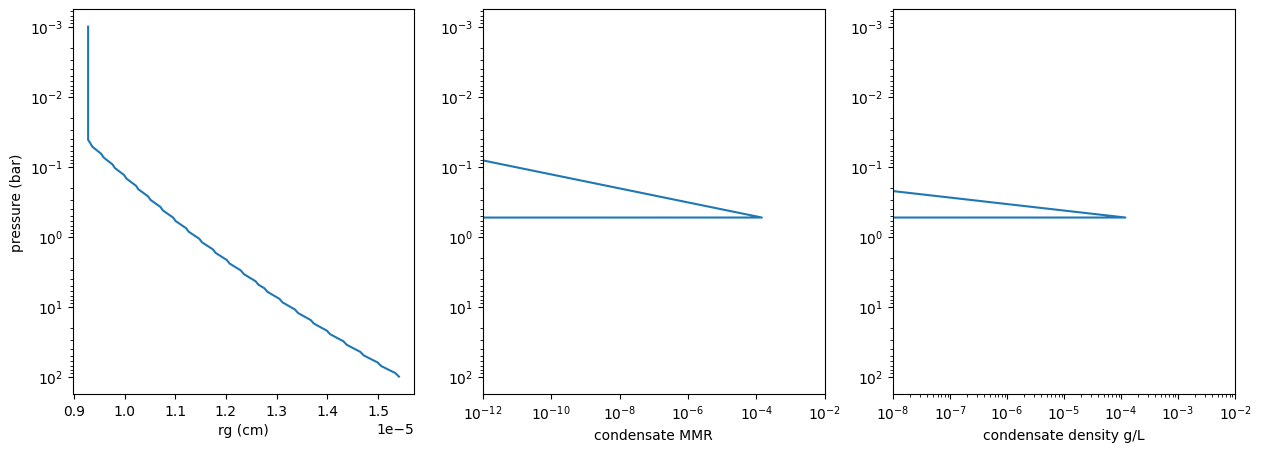

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
plt.plot(rg_layer,Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(132)
plt.plot(MMRc,Parr)
plt.xlabel("condensate MMR")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-12, 1e-2)
ax.invert_yaxis()
ax = fig.add_subplot(133)
plt.plot(fac*MMRc,Parr)
plt.xlabel("condensate density g/L")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-8, 1e-2)
ax.invert_yaxis()

`rg` is almost constant through the vertical distribution. So, let's set a mean value here. 

If you've already generated the miegrid, `miegrid_interpolated_value` method interpolates the original parameter set given by MiQ_lognormal in PyMieScatt. 
See https://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_Lognormal. The number of the original parameters are seven, Bext, Bsca, Babs, G, Bpr, Bback, and Bratio. 

If not yet, `opa.mieparams_vector_direct_from_pymiescatt` directly calls the PyMieScatt and computes the Mie parameters.

In [8]:
rg = 1e-5

Plots the extinction coefficient for instance (index=0) and some approximation from the Kevin Heng's textbook .

To handle the opacity for Mie scattering, we call `OpaMie` class as `opa`.  
The mie parameters can be derived by `mieparams_vector` method, which returns $\beta_0$: the extinction coefficient of the reference number density $N_0$, $\omega$: a single scattering albedo , and $g$: the asymmetric parameter.

In [9]:

from exojax.spec.opacont import OpaMie
opa = OpaMie(pdb_nh3, nus)
#sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector(rg,sigmag) # if using MieGrid
sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector_direct_from_pymiescatt(rg, sigmag)

100%|██████████| 131/131 [00:28<00:00,  4.59it/s]


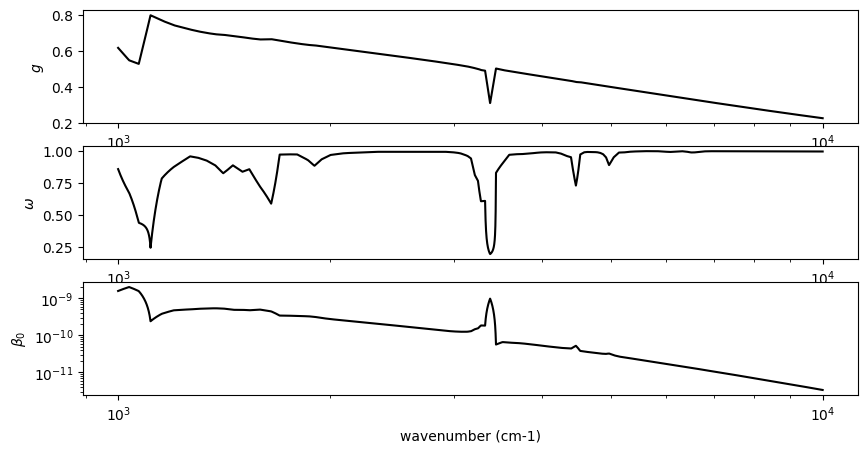

In [10]:
# plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
plt.plot(nus, asymmetric_factor, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(nus, sigma_scattering/sigma_extinction, label="single scattering albedo", color="black")
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(nus, sigma_extinction, label="ext", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
plt.savefig("miefig.png")

## Reflection spectrum

The opacity of the lognormal cloud model can be computed using `opacity_profile_cloud_lognormal` method in `art`.

In [11]:
dtau = art.opacity_profile_cloud_lognormal(sigma_extinction, rhoc, MMRc, rg, sigmag, gravity)

To compute the reflection spectrum, we need the single scattering albedo, asymmetric parameter (known as g, but confusing from gravity), and the surface reflectivity.

In [17]:
single_scattering_albedo = sigma_scattering[None,:]/sigma_extinction[None,:] + np.zeros((len(art.pressure), len(nus)))
asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus)))
reflectivity_surface = np.zeros(len(nus))

The incoming flux is normalized to 1. So, the output should be refelectivity.

In [18]:
incoming_flux = np.ones(len(nus))
Fr = art.run(dtau,single_scattering_albedo,asymmetric_parameter,reflectivity_surface,incoming_flux)

Here are the results.

Text(0.5, 0, 'wavenumber (cm-1)')

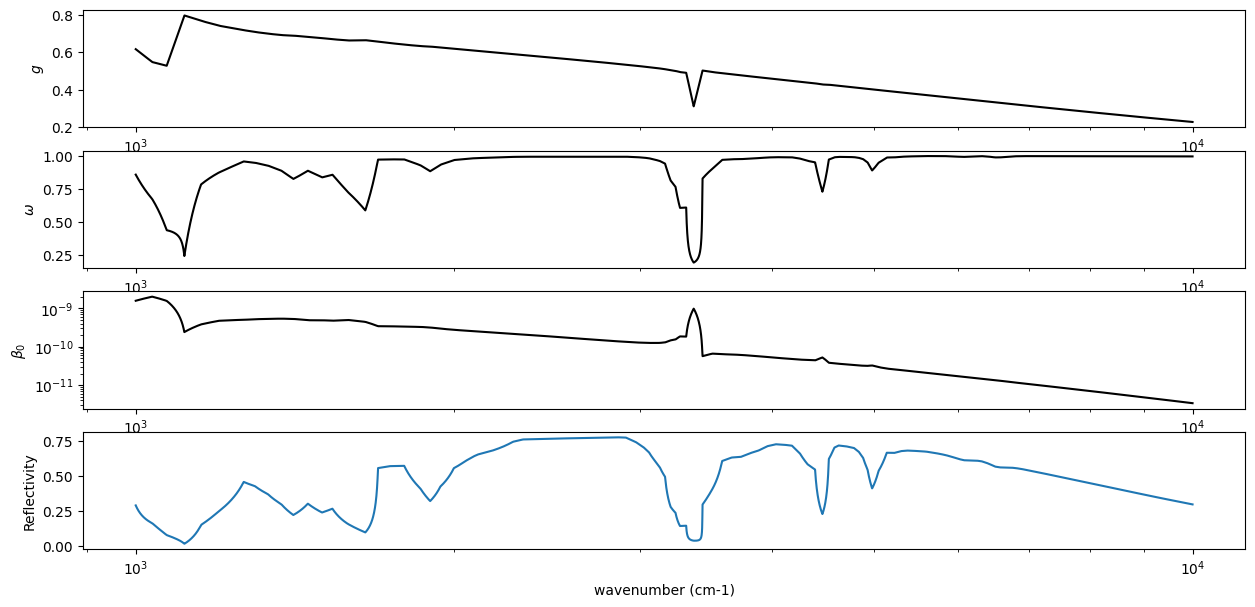

In [20]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(411)
plt.plot(nus, asymmetric_factor, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(412)
plt.plot(nus, sigma_scattering/sigma_extinction, label="single scattering albedo", color="black")
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(413)
plt.plot(nus, sigma_extinction, label="ext", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
ax = fig.add_subplot(414)
plt.plot(nus,Fr)
plt.xscale("log")
plt.ylabel("Reflectivity")
plt.xlabel("wavenumber (cm-1)")